In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

def get_table(table_name):
    query = f"""
    SELECT * 
    FROM `red-bull-case-1.redbull.{table_name}`
    """
    df = client.query(query).to_dataframe()

    return df

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/ronnieasatourian/Desktop/F1 Case/red-bull-case-1-ab62fe2d9df9.json'
client = bigquery.Client()


fact_table_df = get_table('fact_table')
driver_dim_df = get_table('driver_dim')
race_event_dim_df = get_table('race_event_dim')
season_dim_df = get_table('season_dim')
team_dim_df = get_table('team_dim')
venue_dim_df = get_table('venue_dim')


merged_df = fact_table_df.merge(driver_dim_df, on='DriverId')
merged_df = merged_df.merge(team_dim_df, on='TeamId')
merged_df = merged_df.merge(race_event_dim_df, on='RaceId')
merged_df = merged_df.merge(season_dim_df, on='SeasonId')
merged_df = merged_df.merge(venue_dim_df, on='VenueId')




# Correlation Analysis

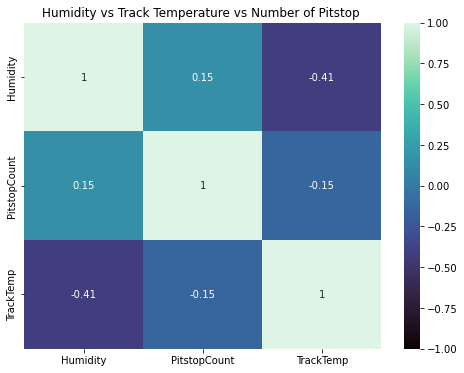

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = merged_df[['Humidity', 'PitstopCount','TrackTemp']]

plt.figure(figsize=(8, 6))
corr = heatmap_data.corr()
sns.heatmap(corr, annot=True, cmap='mako', vmin=-1, vmax=1)
plt.title('Humidity vs Track Temperature vs Number of Pitstop ')
plt.show()

# Regression Analysis

In [5]:
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor


merged_df.dropna(inplace=True)

X = merged_df.drop(['FinalPosition', 'RacePerformanceId', 'RaceId', 'DriverId', 'TeamId', 'VenueId', 'SeasonId', 'ScheduledStart', 'ScheduledEnd', 'StartDate', 'EndDate', 
                    'IndividualPoints'], axis=1)
y = merged_df['FinalPosition']

def new_func(X, y):
    
    X = pd.get_dummies(X, drop_first=True)

    # Lasso for feature selection
    lasso = Lasso(alpha=0.3)
    lasso_coef = lasso.fit(X, y).coef_
    selected_features = X.columns[lasso_coef != 0]
    X_selected = X[selected_features]
    return X_selected

X_selected = new_func(X, y)

# VIF to reduce Multicollinearity
vif_data = pd.DataFrame()
vif_data['feature'] = X_selected.columns
vif_data['VIF'] = [variance_inflation_factor(X_selected.values.astype(float), i) for i in range(X_selected.shape[1])]

high_vif_features = vif_data[vif_data['VIF'] > 7]['feature']  # We will Adjust the VIF threshold as needed
X_selected_reduced = X_selected.drop(columns=high_vif_features)

X_selected_reduced = sm.add_constant(X_selected_reduced)
model_final_reduced = sm.OLS(y.astype(float), X_selected_reduced.astype(float)).fit()

print(model_final_reduced.summary())


                            OLS Regression Results                            
Dep. Variable:          FinalPosition   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     1103.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:27:54   Log-Likelihood:                -5596.7
No. Observations:                2278   AIC:                         1.120e+04
Df Residuals:                    2275   BIC:                         1.122e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.5361      0.172      8.925   

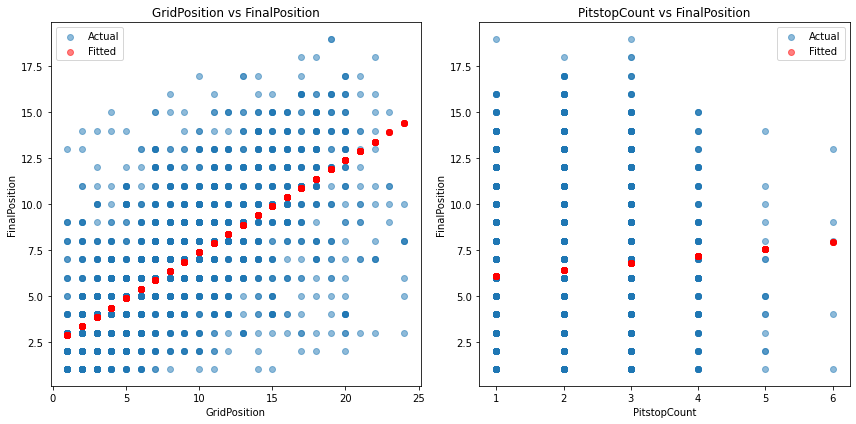

In [6]:

X_grid = sm.add_constant(merged_df['GridPosition'])  # For GridPosition
X_pitstop = sm.add_constant(merged_df['PitstopCount'])  # For PitstopCount

model_grid = sm.OLS(y.astype(float), X_grid.astype(float)).fit()
model_pitstop = sm.OLS(y.astype(float), X_pitstop.astype(float)).fit()

fitted_values_grid = model_grid.fittedvalues
fitted_values_pitstop = model_pitstop.fittedvalues

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.scatter(merged_df['GridPosition'], y, alpha=0.5, label='Actual')
plt.scatter(merged_df['GridPosition'], fitted_values_grid, alpha=0.5, color='red', label='Fitted')
plt.title('GridPosition vs FinalPosition')
plt.xlabel('GridPosition')
plt.ylabel('FinalPosition')
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(merged_df['PitstopCount'], y, alpha=0.5, label='Actual')
plt.scatter(merged_df['PitstopCount'], fitted_values_pitstop, alpha=0.5, color='red', label='Fitted')
plt.title('PitstopCount vs FinalPosition')
plt.xlabel('PitstopCount')
plt.ylabel('FinalPosition')
plt.legend()

plt.tight_layout()
plt.show()


# Data Processing & Time series and forecasting

In [2]:
rb_team_df = merged_df[merged_df['TeamName'] == 'Red Bull Racing']


rb_team_df['YearMonth'] = rb_team_df['ScheduledStart'].dt.to_period('M')


rb_team_annual_point = rb_team_df.groupby('YearMonth')['IndividualPoints'].sum().reset_index()
rb_team_annual_point = rb_team_annual_point[(rb_team_annual_point['YearMonth'].dt.year != 2007) & (rb_team_annual_point['YearMonth'].dt.year != 2021)]


new_rows = [
    { 'YearMonth': '2005-03', 'IndividualPoints': 11},
    { 'YearMonth': '2005-04', 'IndividualPoints': 2},
    { 'YearMonth': '2005-05', 'IndividualPoints': 6},
    { 'YearMonth': '2005-06', 'IndividualPoints': 3},
    { 'YearMonth': '2005-07', 'IndividualPoints': 2},
    { 'YearMonth': '2005-08', 'IndividualPoints': 3},
    { 'YearMonth': '2005-09', 'IndividualPoints': 0},
    { 'YearMonth': '2005-10', 'IndividualPoints': 7},
    { 'YearMonth': '2006-03', 'IndividualPoints': 1},
    { 'YearMonth': '2006-04', 'IndividualPoints': 1},
    { 'YearMonth': '2006-05', 'IndividualPoints': 6},
    { 'YearMonth': '2006-06', 'IndividualPoints': 1},
    { 'YearMonth': '2006-07', 'IndividualPoints': 3},
    { 'YearMonth': '2006-08', 'IndividualPoints': 4},
    { 'YearMonth': '2006-09', 'IndividualPoints': 0},
    { 'YearMonth': '2006-10', 'IndividualPoints': 0},
    { 'YearMonth': '2007-03', 'IndividualPoints': 0},
    { 'YearMonth': '2007-04', 'IndividualPoints': 0},
    { 'YearMonth': '2007-05', 'IndividualPoints': 4},
    { 'YearMonth': '2007-06', 'IndividualPoints': 2},
    { 'YearMonth': '2007-07', 'IndividualPoints': 10},
    { 'YearMonth': '2007-08', 'IndividualPoints': 0},
    { 'YearMonth': '2007-09', 'IndividualPoints': 7},
    { 'YearMonth': '2007-10', 'IndividualPoints': 1},
    { 'YearMonth': '2021-03', 'IndividualPoints': 28},
    { 'YearMonth': '2021-04', 'IndividualPoints': 25},
    { 'YearMonth': '2021-05', 'IndividualPoints': 96},
    { 'YearMonth': '2021-06', 'IndividualPoints': 103},
    { 'YearMonth': '2021-07', 'IndividualPoints': 37},
    { 'YearMonth': '2021-08', 'IndividualPoints': 14.5},
    { 'YearMonth': '2021-09', 'IndividualPoints': 61},
    { 'YearMonth': '2021-10', 'IndividualPoints': 73},
    { 'YearMonth': '2021-11', 'IndividualPoints': 104},
    { 'YearMonth': '2021-12', 'IndividualPoints': 44},
    { 'YearMonth': '2022-03', 'IndividualPoints': 37.0},
    { 'YearMonth': '2022-04', 'IndividualPoints': 76.0},
    { 'YearMonth': '2022-05', 'IndividualPoints': 122.0},
    { 'YearMonth': '2022-06', 'IndividualPoints': 69.0},
    { 'YearMonth': '2022-07', 'IndividualPoints': 127.0},
    { 'YearMonth': '2022-08', 'IndividualPoints': 44.0},
    { 'YearMonth': '2022-09', 'IndividualPoints': 70.0},
    { 'YearMonth': '2022-10', 'IndividualPoints': 151.0},
    { 'YearMonth': '2022-11', 'IndividualPoints': 63.0},
    { 'YearMonth': '2023-03', 'IndividualPoints': 87},
    { 'YearMonth': '2023-04', 'IndividualPoints': 93},
    { 'YearMonth': '2023-05', 'IndividualPoints': 69},
    { 'YearMonth': '2023-06', 'IndividualPoints': 72},
    { 'YearMonth': '2023-07', 'IndividualPoints': 182},
    { 'YearMonth': '2023-08', 'IndividualPoints': 37},
    { 'YearMonth': '2023-09', 'IndividualPoints': 83},
    { 'YearMonth': '2023-10', 'IndividualPoints': 108},
    { 'YearMonth': '2023-11', 'IndividualPoints': 129}   
]


new_rows_df = pd.DataFrame(new_rows)
new_rows_df['YearMonth'] = pd.to_datetime(new_rows_df['YearMonth']).dt.to_period('M')

rb_team_annual_point = rb_team_annual_point.append(new_rows_df, ignore_index=True)
rb_team_annual_point = rb_team_annual_point.sort_values(by='YearMonth', ascending=True).reset_index(drop=True)


start_date = '2005-01'
end_date = '2023-12'


all_months = pd.period_range(start=start_date, end=end_date, freq='M')
all_months_df = pd.DataFrame(all_months, columns=['YearMonth'])


full_data = all_months_df.merge(rb_team_annual_point, on='YearMonth', how='left')
full_data['IndividualPoints'] = full_data['IndividualPoints'].fillna(0)


full_data = full_data.sort_values(by='YearMonth').reset_index(drop=True)

full_data.to_csv('/Users/ronnieasatourian/Desktop/Rb-points.csv',index=False)

In [3]:
full_data

,YearMonth,IndividualPoints
0,2005-01,0.0
1,2005-02,0.0
2,2005-03,11.0
3,2005-04,2.0
4,2005-05,6.0
...,...,...
223,2023-08,37.0
224,2023-09,83.0
225,2023-10,108.0
226,2023-11,129.0
